# let's make a classifier to help prune the labeled markets 

In [ ]:
import pandas as pd

# hand labeled set 
df = pd.read_csv("all_markets.csv")

                market_id  Unnamed: 1  \
0              nOsIQhz8c0           0   
1              lRqgh0sZZ6           0   
2              th0c0iplmn           0   
3    wfXXAYtnp0xwUYR0N6Ey           0   
4    Ck5cxsXHlxgIrVfLuYZ3           0   
..                    ...         ...   
156  kOSowwxJlt0SD7ar2VzZ           1   
157  8tMPNCIpCmegh5wdyaf1           1   
158  AkFr9bkvraIoIDdQZrpH           1   
159  iuIS0vt6WW4LatwbB7il           1   
160  LDyBGgoUpRf9EuaxBGcd           1   

                                              question  \
0    <10% US households cook own food manually by 2040   
1    Will 1000 people reportedly die from the unkno...   
2    Is the first Cockatoo/macaw to reach age 150 y...   
3    Will RawChickenExperiment eat raw chicken for ...   
4    Will RawChickenExperiment eat raw chicken for ...   
..                                                 ...   
156       Will chicken be banned in Texas before 2050?   
157  Will chicken be banned in the united s

# use the same embedding as the OG

In [6]:
from sklearn.model_selection import train_test_split

# Split data into train, val, and test sets for all models
X_train, X_temp, y_train, y_temp = train_test_split(
    df['question'], df['Unnamed: 1'], test_size=0.4, stratify=df['Unnamed: 1'], random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# to use for final test once model parameters are chosen
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

In [7]:
from sentence_transformers import SentenceTransformer
import numpy as np

model = SentenceTransformer('Alibaba-NLP/gte-base-en-v1.5', trust_remote_code=True)

In [8]:
# Encode only the training, val, and test sets separately
X_train_Alibaba = model.encode(X_train.tolist())
X_val_Alibaba = model.encode(X_val.tolist())
X_test_Alibaba = model.encode(X_test.tolist())

X_train_val_Alibaba = np.concatenate([X_train_Alibaba, X_val_Alibaba])
y_train_val_Alibaba = np.concatenate([y_train, y_val])


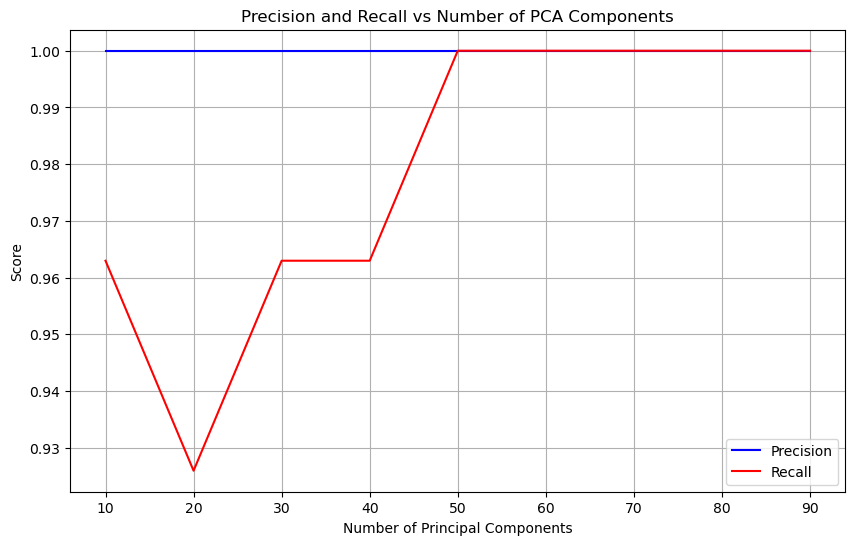


Best performance at 50 components:
Precision: 1.000
Recall: 1.000


In [11]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

np.random.seed(42)

# Calculate max components
n_samples, n_features = X_train_Alibaba.shape
max_components = min(n_samples, n_features)
component_steps = range(10, max_components + 1, 10)

precisions = []
recalls = []

for n_components in component_steps:
    # Apply PCA
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_Alibaba)
    X_val_pca = pca.transform(X_val_Alibaba)
    
    # Train classifier
    clf = make_pipeline(StandardScaler(),
                    LinearSVC(random_state=42, max_iter=20000, dual ='auto'))
    clf.fit(X_train_pca, y_train)
    
    # Make predictions
    y_pred = clf.predict(X_val_pca)
    
    # Calculate metrics
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    
    precisions.append(precision)
    recalls.append(recall)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(component_steps, precisions, 'b-', label='Precision')
plt.plot(component_steps, recalls, 'r-', label='Recall')
plt.xlabel('Number of Principal Components')
plt.ylabel('Score')
plt.title('Precision and Recall vs Number of PCA Components')
plt.legend()
plt.grid(True)
plt.show()

# Print the best results
best_idx = np.argmax([p + r for p, r in zip(precisions, recalls)])
print(f"\nBest performance at {component_steps[best_idx]} components:")
print(f"Precision: {precisions[best_idx]:.3f}")
print(f"Recall: {recalls[best_idx]:.3f}") 

In [ ]:
clf = make_pipeline(StandardScaler(),
                    PCA(n_components=50 , random_state=42),
                    LinearSVC(random_state=42, tol=1e-5, max_iter=20000, dual ='auto'))

clf.fit(X_train_val_Alibaba, y_train_val_Alibaba)



Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=50, random_state=42)),
                ('linearsvc',
                 LinearSVC(dual='auto', max_iter=20000, random_state=42,
                           tol=1e-05))])

In [16]:
import joblib

# Save the model to a file
joblib.dump(clf, 'my_classifier.joblib')

['my_classifier.joblib']

In [15]:
test_question = "Will anyone die with H5 bird flu in the US in 2025?"
test_question_embedding = model.encode(test_question).reshape(1, -1)

print(clf.predict(test_question_embedding))


[1]
